In [74]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve



In [75]:
# Daten laden
def load_and_prepare_data(filepath, exclude_features=None):
    """Lädt den Mushroom-Datensatz, bereinigt fehlende Werte und kodiert die Zielvariable.
       exclude_features: Liste von Spaltennamen, die ausgeschlossen werden sollen."""
    df = pd.read_csv(filepath)
    print(f"Datensätze geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten.")
    
    # Fehlende Werte ("?") in 'stalk-root' entfernen
    if (df['stalk-root'] == '?').any():
        df = df[df['stalk-root'] != '?'].reset_index(drop=True)
        print(f"Nach Entfernen fehlender stalk-root Werte: {df.shape[0]} Zeilen")
    
    # Zielvariable kodieren ('e' -> 0, 'p' -> 1)
    df['target'] = df['class'].map({'e': 0, 'p': 1})
    
    # Gegebenenfalls Features ausschließen
    if exclude_features:
        df.drop(columns=exclude_features, inplace=True, errors='ignore')
        print(f"Folgende Merkmale wurden ausgeschlossen: {exclude_features}")
    
    # Features und Zielvariable trennen
    X = df.drop(columns=['class', 'target'])
    y = df['target']
    print("Verbleibende Features:", list(X.columns))
    print("Klassenverteilung (target 0=essbar, 1=giftig):", np.bincount(y))
    return X, y

# Beispiel: Liste starker Merkmale, die optional ausgeschlossen werden können
strong_features = [
    'odor', 'spore-print-color', 'ring-type', 'gill-color',
    'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring'
]

# Daten laden (Standard: keine Merkmale ausgeschlossen)
X, y = load_and_prepare_data('data/mushrooms.csv', exclude_features=None)

Datensätze geladen: 8124 Zeilen, 23 Spalten.
Nach Entfernen fehlender stalk-root Werte: 5644 Zeilen
Verbleibende Features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Klassenverteilung (target 0=essbar, 1=giftig): [3488 2156]


Train/Test SPilt

In [76]:
# Stratified Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Trainingsdaten: {X_train.shape[0]} Beispiele, Testdaten: {X_test.shape[0]} Beispiele")
print("Klassenverteilung im Training:", np.bincount(y_train))
print("Klassenverteilung im Test:", np.bincount(y_test))

# Cross-Validation Definition (5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Trainingsdaten: 4515 Beispiele, Testdaten: 1129 Beispiele
Klassenverteilung im Training: [2790 1725]
Klassenverteilung im Test: [698 431]


One-Hot-Encoding und Pipeline-Vorbereitung

In [77]:
# Kategoriale Spalten festlegen (alle verbleibenden Merkmale)
categorical_cols = X_train.columns.tolist()

# One-Hot Encoder als Vorverarbeitungsschritt definieren
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_preprocessor = ColumnTransformer(
    transformers=[('onehot', onehot_encoder, categorical_cols)],
    remainder='drop'
)

pipleine erstellen

In [78]:

def build_pipeline(model_name):
    """Erstellt eine Pipeline mit One-Hot-Encoding (und ggf. Skalierung/Feature-Selection) 
       gefolgt vom gewünschten Modell."""
    if model_name == 'LogisticRegression':
        return Pipeline([
            ('enc', ohe_preprocessor),
            ('scale', StandardScaler(with_mean=False)),  # mit_mean=False, da One-Hot (keine Zentrierung nötig)
            ('clf', LogisticRegression(max_iter=10000, random_state=42))
        ])
    elif model_name == 'RandomForest':
        return Pipeline([
            ('enc', ohe_preprocessor),
            ('feature_sel', SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')),
            ('clf', RandomForestClassifier(random_state=42))
        ])
    elif model_name == 'XGBoost':
        return Pipeline([
            ('enc', ohe_preprocessor),
            ('feature_sel', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), threshold='median')),
            ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
        ])
    else:
        raise ValueError(f"Unbekanntes Modell: {model_name}")

# Pipelines für die drei Modelltypen erzeugen
pipeline_lr = build_pipeline('LogisticRegression')
pipeline_rf = build_pipeline('RandomForest')
pipeline_xgb = build_pipeline('XGBoost')


Baseline-Modelltraining und -Bewertung

In [79]:

baseline_results = []
baseline_models = {}

for model_name, pipeline in zip(
        ['Logistic Regression', 'Random Forest', 'XGBoost'],
        [pipeline_lr, pipeline_rf, pipeline_xgb]):

    # 1) Pipeline trainieren
    pipeline.fit(X_train, y_train)
    baseline_models[model_name] = pipeline

    # 2) Merkmale transformieren (One-Hot + ggf. Feature-Selection)
    #    pipeline[:-1] = alle Schritte außer dem letzten ('clf')
    X_train_feat = pipeline[:-1].transform(X_train)
    X_test_feat  = pipeline[:-1].transform(X_test)

    # 3) Letzten Schritt holen (Klassifikator)
    clf = pipeline.named_steps['clf']

    # 4) Manuelle Vorhersage mit dem Klassifikator
    y_train_pred = clf.predict(X_train_feat)
    y_test_pred  = clf.predict(X_test_feat)

    # 5) Kennzahlen berechnen
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test,  y_test_pred)
    roc_auc   = roc_auc_score(y_test, clf.predict_proba(X_test_feat)[:, 1])

    baseline_results.append({
        'Model': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'ROC-AUC': roc_auc,
        'Overfit_gap': train_acc - test_acc
    })


baseline_df = pd.DataFrame(baseline_results).sort_values('Model').reset_index(drop=True)
display(baseline_df)

/home/parallels/miniconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:19:45] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Train Accuracy,Test Accuracy,ROC-AUC,Overfit_gap
0,Logistic Regression,1.0,1.0,1.0,0.0
1,Random Forest,1.0,1.0,1.0,0.0
2,XGBoost,1.0,1.0,1.0,0.0


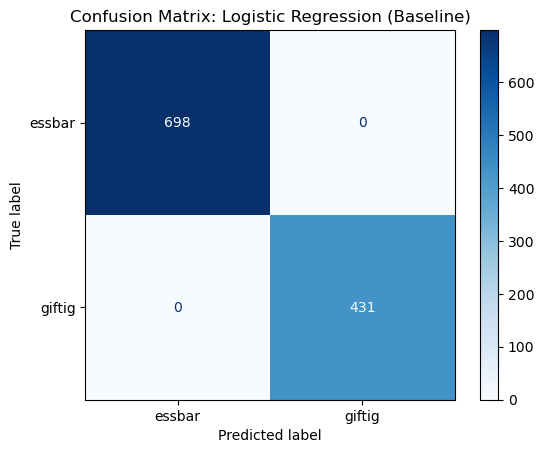

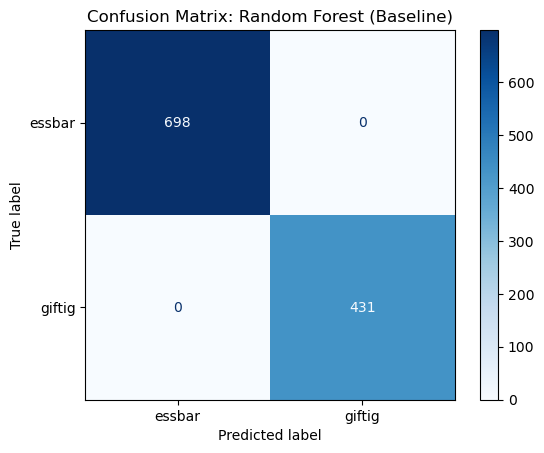

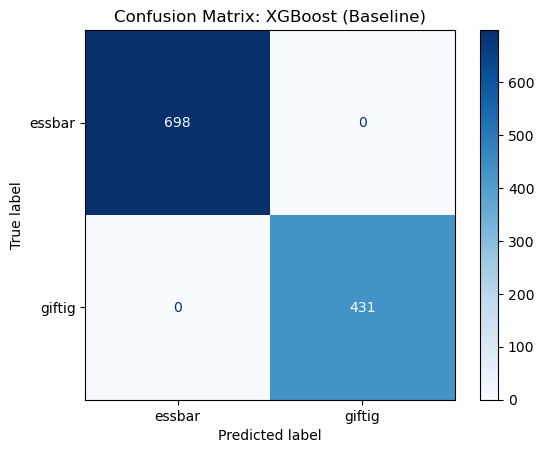

In [80]:
# Konfusionsmatrix für jedes Baseline-Modell per from_predictions
for model_name, pipeline in baseline_models.items():
    # 1) Merkmals-Transformation (OneHot + ggf. Feature-Selection)
    X_test_feat = pipeline[:-1].transform(X_test)
    # 2) Klassifikator extrahieren
    clf = pipeline.named_steps['clf']
    # 3) Vorhersagen berechnen
    y_pred = clf.predict(X_test_feat)

    # 4) ConfusionMatrixDisplay.from_predictions aufrufen
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=['essbar','giftig'],
        cmap=plt.cm.Blues,
        normalize=None
    )
    disp.ax_.set_title(f"Confusion Matrix: {model_name} (Baseline)")
    plt.show()

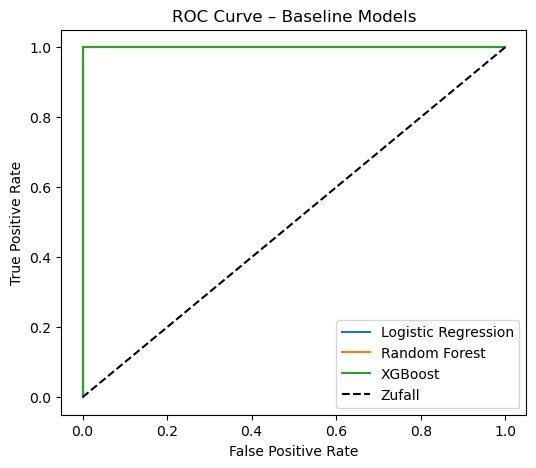

In [81]:


plt.figure(figsize=(6,5))

for model_name, pipeline in baseline_models.items():
    # 1) Feature-Transformation (One-Hot + evtl. Feature-Selection)
    X_test_feat = pipeline[:-1].transform(X_test)
    # 2) Klassifikator extrahieren
    clf = pipeline.named_steps['clf']
    # 3) Score-Wahrscheinlichkeiten holen
    y_score = clf.predict_proba(X_test_feat)[:, 1]
    # 4) ROC-Kurvendaten berechnen
    fpr, tpr, _ = roc_curve(y_test, y_score)
    # 5) Kurve plotten
    plt.plot(fpr, tpr, label=model_name)

# Diagonale als Zufallsbaseline
plt.plot([0,1], [0,1], 'k--', label='Zufall')

plt.title("ROC Curve – Baseline Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


Hyperparameter-Tuning und erneute Bewertung

In [83]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Hyperparameter-Tuning durchführen
tuned_results = []
tuned_models = {}

for model_name, param_dist in param_dists.items():
    print(f"*** Hyperparameter-Tuning für {model_name} ***")
    n_iter = 20 if model_name == 'Logistic Regression' else 30
    search = RandomizedSearchCV(
        estimator=pipelines[model_name],
        param_distributions=param_dist,
        n_iter=n_iter, cv=cv, scoring='accuracy',
        n_jobs=-1, random_state=42, verbose=1
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    tuned_models[model_name] = best_model

    # Manuelle Leistungs­berechnung:
    # Transformiere Features (ohne Klassifikator)
    X_train_feat = best_model[:-1].transform(X_train)
    X_test_feat  = best_model[:-1].transform(X_test)
    # Hole den Klassifikator
    clf = best_model.named_steps['clf']
    # Vorhersagen erzeugen
    y_train_pred = clf.predict(X_train_feat)
    y_test_pred  = clf.predict(X_test_feat)
    # Kennzahlen
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test,  y_test_pred)
    roc_auc   = roc_auc_score(y_test, clf.predict_proba(X_test_feat)[:, 1])

    tuned_results.append({
        'Model': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'ROC-AUC': roc_auc,
        'Overfit_gap': train_acc - test_acc
    })

    print(f"Beste Parameter für {model_name}: {search.best_params_}")
    print(f"-> Accuracy (Test): {test_acc:.4f}, ROC-AUC (Test): {roc_auc:.4f}\n")

import pandas as pd
tuned_df = pd.DataFrame(tuned_results).sort_values('Model').reset_index(drop=True)
print("Tuned Model Performance:")
display(tuned_df)


*** Hyperparameter-Tuning für Logistic Regression ***
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste Parameter für Logistic Regression: {'clf__solver': 'saga', 'clf__penalty': 'l1', 'clf__C': np.float64(1.34062995298927)}
-> Accuracy (Test): 1.0000, ROC-AUC (Test): 1.0000

*** Hyperparameter-Tuning für Random Forest ***
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Beste Parameter für Random Forest: {'clf__n_estimators': np.int64(492), 'clf__min_samples_split': np.int64(13), 'clf__max_features': 'log2', 'clf__max_depth': None}
-> Accuracy (Test): 1.0000, ROC-AUC (Test): 1.0000

*** Hyperparameter-Tuning für XGBoost ***
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/parallels/miniconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:23:50] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parallels/miniconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:23:50] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parallels/miniconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:23:50] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/parallels/miniconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:23:50] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encod

Beste Parameter für XGBoost: {'clf__subsample': np.float64(0.9509138180665104), 'clf__n_estimators': np.int64(242), 'clf__max_depth': np.int64(25), 'clf__learning_rate': np.float64(0.08987439951801368)}
-> Accuracy (Test): 1.0000, ROC-AUC (Test): 1.0000

Tuned Model Performance:


,Model,Train Accuracy,Test Accuracy,ROC-AUC,Overfit_gap
0,Logistic Regression,1.0,1.0,1.0,0.0
1,Random Forest,1.0,1.0,1.0,0.0
2,XGBoost,1.0,1.0,1.0,0.0


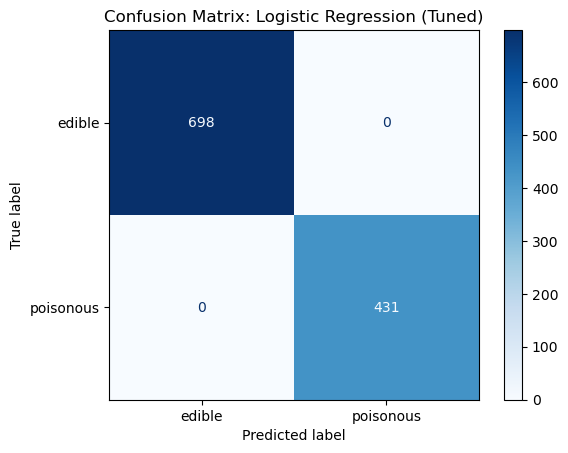

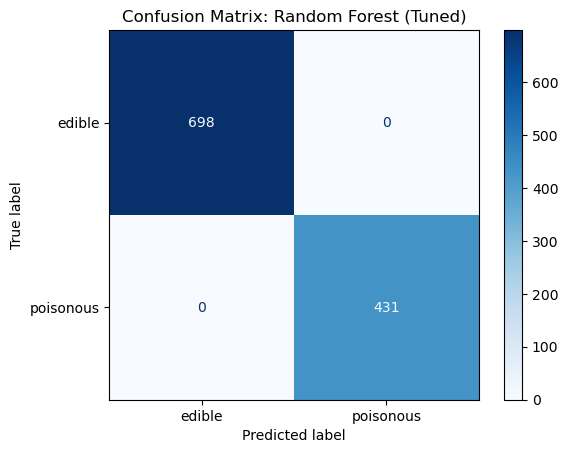

ValueError: ConfusionMatrixDisplay.from_estimator only supports classifiers

In [84]:
# Konfusionsmatrizen für getunte Modelle
for model_name, model in tuned_models.items():
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=['edible','poisonous'], cmap=plt.cm.Blues, normalize=None
    )
    disp.ax_.set_title(f"Confusion Matrix: {model_name} (Tuned)")
    plt.show()

AttributeError: 'super' object has no attribute '__sklearn_tags__'

<Figure size 600x500 with 0 Axes>

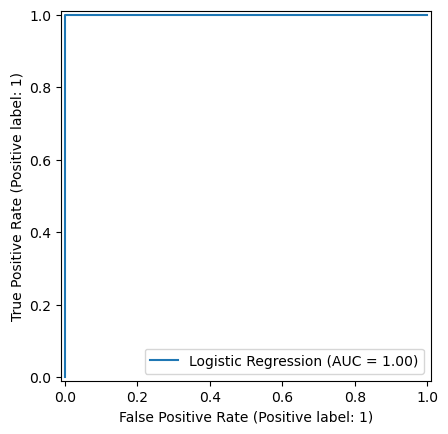

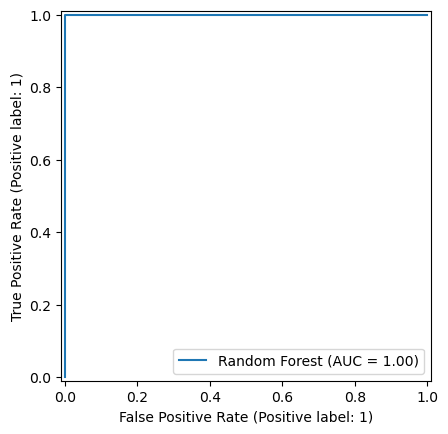

In [85]:
# ROC-Kurven der getunten Modelle vergleichen
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(tuned_models['Logistic Regression'], X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(tuned_models['Random Forest'], X_test, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(tuned_models['XGBoost'], X_test, y_test, name="XGBoost")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Tuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
